### Metabolic Flux Analysis

In [279]:
import csv
from cmath import exp, log
import cobra
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize_scalar
from scipy.stats import norm
import random
import copy

In [280]:
Dry2Wet = 0.1

### 1. MODEL

In [281]:
class FBA:
    def __init__(self):
        # open the model
        self.model = cobra.io.read_sbml_model("iJTC6240_in_SBML.xml")

        # mmol_per_gDW_per_hr

        met_0429 = self.model.metabolites.get_by_id("met_0429") # CO2 cytosol
        met_0430 = self.model.metabolites.get_by_id("met_0430") # CO2 mitochondria
        met_0431 = self.model.metabolites.get_by_id("met_0431") # CO2 periplasm
        met_0432 = self.model.metabolites.get_by_id("met_0432") # CO2 peroxisome

        met_2737 = self.model.metabolites.get_by_id("met_2737") # squalene

        CO2_consumption = self.model.reactions.get_by_id('reac_1169')
        self.model.reactions.get_by_id('reac_1169').bounds = (0.8, 0.88) # photosynthesis
        self.model.reactions.get_by_id('reac_0443').bounds = (30, 39) # CO2 uptake
        # photosynthesis: 20 umol CO2 per m^2 per s
        # 20/1000*60*60*2/1700/(0.1) = 0.847
        # leaf avg: 2m^2 1700g
        # assume 10% dry weight

        # CO2 amount in the cell
        # avg: 210 umol CO2 per mol air

        met_1352 = self.model.metabolites.get_by_id("met_1352")
        met_0417 = self.model.metabolites.get_by_id("met_0417")
        met_0418 = self.model.metabolites.get_by_id("met_0418") # chlorogenic acid
        met_2715 = self.model.metabolites.get_by_id("met_2715") # shikimate
        met_0419 = self.model.metabolites.get_by_id("met_0419") # caffeoyl shikimate
        met_2888 = self.model.metabolites.get_by_id("met_2888") # H2O
        met_2632 = self.model.metabolites.get_by_id("met_2632") # quinate
        met_2386 = self.model.metabolites.get_by_id("met_2386") # NADPH
        met_2591 = self.model.metabolites.get_by_id("met_2591") # H+
        met_2382 = self.model.metabolites.get_by_id("met_2382") # NADP+
        met_2378 = self.model.metabolites.get_by_id("met_2378") # NADH
        met_2372 = self.model.metabolites.get_by_id("met_2372") # NAD+
        met_1838 = self.model.metabolites.get_by_id("met_1838") # 3-dehydroquinate
        met_0110 = self.model.metabolites.get_by_id("met_0110") # 3-dehydroshikimate
        met_0079 = self.model.metabolites.get_by_id("met_0079") # 2-O-caffeoylglucarate
        met_1795 = self.model.metabolites.get_by_id("met_1795") # glucarate
        met_2521 = self.model.metabolites.get_by_id("met_2521") # PEP
        met_1953 = self.model.metabolites.get_by_id("met_1953") # E4P
        met_2544 = self.model.metabolites.get_by_id("met_2544") # Pi
        met_0112 = self.model.metabolites.get_by_id("met_0112") # DAHP
        met_0512 = self.model.metabolites.get_by_id('met_0512') # CoA
        met_0367 = self.model.metabolites.get_by_id('met_0367') # ATP
        met_0344 = self.model.metabolites.get_by_id('met_0344') # AMP
        met_2566 = self.model.metabolites.get_by_id('met_2566') # diphosphate
        met_0339 = self.model.metabolites.get_by_id('met_0339')
        met_2238 = self.model.metabolites.get_by_id('met_2238') # L-dopa
        
        # self.model.reactions.get_by_id('reac_0223').bounds = (0, 4)
        # self.model.reactions.get_by_id('reac_2010').bounds = (0.01, 0.03)
        # self.model.reactions.get_by_id('reac_0066').bounds = (0.01, 0.03)
        self.model.reactions.get_by_id('reac_1317').bounds = (0, 0.5)
        self.model.reactions.get_by_id('reac_2013').bounds = (-1000, 1000)


        # restrict = self.model.problem.Constraint(
        # self.model.reactions.reac_1317.flux_expression - self.model.reactions.reac_0223.flux_expression,
        # lb=-4,
        # ub=4)
        # self.model.add_cons_vars(restrict)

        # 4CL
        R_4CL = cobra.Reaction('4CL')
        R_4CL.add_metabolites({met_1352: -1, met_0367: -1, met_0512: -1,
                               met_0417: 1, met_0344: 1, met_2566: 1})
        R_4CL.bounds = (0, 1000)
        self.model.add_reactions([R_4CL])

        # CSE
        R_CSE = cobra.Reaction('CSE')
        R_CSE.add_metabolites({met_0419: -1, met_2888: -1, met_2715: 1, met_1352: 1})
        R_CSE.bounds = (0, 1000)
        self.model.add_reactions([R_CSE])
        
        # quinate dehydrogenase
        R_quinate_dehydrogenase1 = cobra.Reaction('quinate_dehydrogenase1')
        R_quinate_dehydrogenase1.add_metabolites({met_2632: -1, met_2382: -1, met_1838: 1, met_2386: 1, met_2591: 1})
        R_quinate_dehydrogenase1.bounds = (-1000, 1000)
        R_quinate_dehydrogenase2 = cobra.Reaction('quinate_dehydrogenase2')
        R_quinate_dehydrogenase2.add_metabolites({met_2632: -1, met_2372: -1, met_1838: 1, met_2378: 1, met_2591: 1})
        R_quinate_dehydrogenase2.bounds = (-1000, 1000)
        self.model.add_reactions([R_quinate_dehydrogenase1, R_quinate_dehydrogenase2])

        # dehydroquinate dehydratase
        R_dehydroquinate_dehydratase = cobra.Reaction('dehydroquinate_dehydratase')
        R_dehydroquinate_dehydratase.add_metabolites({met_1838: -1, met_0110: 1, met_2888: 1})
        R_dehydroquinate_dehydratase.bounds = (-1000, 1000)
        self.model.add_reactions([R_dehydroquinate_dehydratase])

        # 2-O-caffeoylglucarate tx
        R_2_O_caffeoylglucarate_tx = cobra.Reaction('2_O_caffeoylglucarate_tx')
        R_2_O_caffeoylglucarate_tx.add_metabolites({met_0079: -1})
        R_2_O_caffeoylglucarate_tx.bounds = (-1000, 1000)
        self.model.add_reactions([R_2_O_caffeoylglucarate_tx])

        # glucarate synthesis
        R_glucarate_synthesis = cobra.Reaction('glucarate_synthesis')
        R_glucarate_synthesis.add_metabolites({met_1795: 1})
        R_glucarate_synthesis.bounds = (-1000, 1000)
        self.model.add_reactions([R_glucarate_synthesis])

        # chlorogenic acid proc
        chlorogenic_acid_proc = cobra.Reaction('chlorogenic_acid_proc')
        chlorogenic_acid_proc.add_metabolites({met_0418: -1})
        chlorogenic_acid_proc.bounds = (0, 1000)
        self.model.add_reactions([chlorogenic_acid_proc])
        # chlorogenic acid:
        # 6 mg/gDW
        # 354.31 g/mol
        # 6/354.31 = 1.69e-2 mmol/gDW
        # 8 weeks
        # 1.69e-2/8/7/24 = 1.6e-5 mmol/gDW/hr

        '''
        squalene_proc = cobra.Reaction('squalene_proc')
        squalene_proc.add_metabolites({met_2737: -1})
        model.add_reactions([squalene_proc])

        # squalene: 6 ug/gFW
        # 410 g/mol
        # 10% DW
        # 6/410/1000*(10) = 1.46e-3 mmol/gDW
        '''


        '''
        Caffeoylmalic_acid
        '''      
        # TAL
        R_TAL = cobra.Reaction('R_TAL')
        R_TAL.add_metabolites({met_2238: -1, met_1352: 1, met_0339: 1})
        R_TAL.bounds = (-1000, 2.2)
        self.model.add_reactions([R_TAL])
        

        '''
        Resveratol
        '''
        met_0512 = self.model.metabolites.get_by_id('met_0512') # coenzymeA
        met_2888 = self.model.metabolites.get_by_id('met_2888') # H2O
        met_1953 = self.model.metabolites.get_by_id("met_1953") # D-erythrose4-phosphate
        met_2521 = self.model.metabolites.get_by_id("met_2521") # phosphoenolpyruvate
        met_0112 = self.model.metabolites.get_by_id("met_0112") # 3-deoxy-D-arabino-heptulosonate7-phosphate
        met_2544 = self.model.metabolites.get_by_id("met_2544") # phosphate
        met_2386 = self.model.metabolites.get_by_id("met_2386") # NADPH
        met_2382 = self.model.metabolites.get_by_id("met_2382") # NADP+
        met_0367 = self.model.metabolites.get_by_id('met_0367') # ATP

        # DAHP synthase
        DAHP_synthase = cobra.Reaction('DAHP_synthase')
        DAHP_synthase.add_metabolites({met_1953:-1, met_2521:-1, met_2888:-1, met_0112:1, met_2544:1})
        DAHP_synthase.bounds = (0,1000)
        self.model.add_reactions([DAHP_synthase])
        
        '''
        Crocin
        '''
        met_2556 = self.model.metabolites.get_by_id('met_2556')
        met_0650 = self.model.metabolites.get_by_id('met_0650')
        met_0747 = self.model.metabolites.get_by_id('met_0747')
        met_2552 = self.model.metabolites.get_by_id('met_2552') 
        met_2591 = self.model.metabolites.get_by_id("met_2591") # H+
        met_2378 = self.model.metabolites.get_by_id("met_2378") # NADH
        met_2372 = self.model.metabolites.get_by_id("met_2372") # NAD+
        met_2888 = self.model.metabolites.get_by_id("met_2888") # H2O
        met_1461 = self.model.metabolites.get_by_id("met_1461") 
        met_1462 = self.model.metabolites.get_by_id("met_1462") 
        met_1464 = self.model.metabolites.get_by_id("met_1464") 
        met_1465 = self.model.metabolites.get_by_id("met_1465") 
        met_2554 = self.model.metabolites.get_by_id("met_2554") 
        met_1120 = self.model.metabolites.get_by_id("met_1120") 
        met_0699 = self.model.metabolites.get_by_id("met_0699") 
        met_1675 = self.model.metabolites.get_by_id("met_1675") 
        met_0635 = self.model.metabolites.get_by_id("met_0635") 
        met_1686 = self.model.metabolites.get_by_id("met_1686") 
        met_2838 = self.model.metabolites.get_by_id("met_2838") 
        met_2462 = self.model.metabolites.get_by_id("met_2462") 
        met_2657 = self.model.metabolites.get_by_id("met_2657") 
       

        R_cis_phytoene_desaturase = cobra.Reaction('R_cis_phytoene_desaturase')
        R_cis_phytoene_desaturase.add_metabolites({met_2556:-1, met_0650:-1, met_0747:1, met_2552:1})
        R_cis_phytoene_desaturase.bounds = (0, 1000)

        R_1 = cobra.Reaction('R_1')
        R_1.add_metabolites({met_2554:-1, met_0699:1})
        R_1.bounds = (-1000, 1000)

        R_2 = cobra.Reaction('R_2')
        R_2.add_metabolites({met_1464:-1, met_1465:1})
        R_2.bounds = (-1000, 1000)

        R_3 = cobra.Reaction('R_3')
        R_3.add_metabolites({met_1462:-1, met_1461:1})
        R_3.bounds = (-1000, 1000)

        R_4 = cobra.Reaction('R_4')
        R_4.add_metabolites({met_2462:-1, met_2657:1})
        R_4.bounds = (-1000, 1000)

        R_5 = cobra.Reaction('R_5')
        R_5.add_metabolites({met_1120:-1})
        R_5.bounds = (-1000, 1000)

        R_6 = cobra.Reaction('R_6')
        R_6.add_metabolites({met_2556:-1, met_2552:1})
        R_6.bounds = (-1000, 1000)

        R_7 = cobra.Reaction('R_7')
        R_7.add_metabolites({met_1675:-1, met_0635:1})
        R_7.bounds = (-1000, 1000)

        R_8 = cobra.Reaction('R_8')
        R_8.add_metabolites({met_1686:-1, met_2838:1})
        R_8.bounds = (-1000, 1000)

        self.model.add_reactions([R_1, R_2, R_3, R_4, R_5, R_6, R_7, R_8, R_cis_phytoene_desaturase])

        self.OBJ = self.Calc_biomass() + 0.6633335 * chlorogenic_acid_proc.flux_expression
        # self.OBJ = self.Calc_biomass() + 0.66333349 * chlorogenic_acid_proc.flux_expression

    def Calc_biomass(self):
        # Cell wall
        self.model.reactions.get_by_id('reac_0425').bounds = (0, 1.80) # CELLULOSE
        Cell_wall = self.model.reactions.reac_0425.flux_expression
        # Carbohydrate
        self.model.reactions.get_by_id('reac_0641').bounds = (0.0060, 0.0070) # Glucose
        self.model.reactions.get_by_id('reac_0604').bounds = (0.002, 0.006) # Fructose
        # self.model.reactions.get_by_id('reac_2763').bounds = (0.01, 0.03) # Sucrose
        self.model.reactions.get_by_id('reac_2747').bounds = (0.10, 0.20) # Starch
        Carbohydrate = self.model.reactions.reac_0641.flux_expression +\
            self.model.reactions.reac_0604.flux_expression +\
            self.model.reactions.reac_2763.flux_expression +\
            self.model.reactions.reac_2747.flux_expression 
        # DNA
        self.model.reactions.get_by_id('reac_0483').bounds = (0.0025, 0.0035) # dATP
        self.model.reactions.get_by_id('reac_0488').bounds = (0.0015, 0.0025) # dCTP
        self.model.reactions.get_by_id('reac_0505').bounds = (0.0015, 0.0025) # dGTP
        self.model.reactions.get_by_id('reac_0546').bounds = (0.0025, 0.0035) # dTTP
        DNA = self.model.reactions.reac_0483.flux_expression +\
            self.model.reactions.reac_0488.flux_expression +\
            self.model.reactions.reac_0505.flux_expression +\
            self.model.reactions.reac_0546.flux_expression
        # RNA
        self.model.reactions.get_by_id('reac_0377').bounds = (0.0025, 0.0035) # ATP
        self.model.reactions.get_by_id('reac_0456').bounds = (0.0015, 0.0025) # CTP
        self.model.reactions.get_by_id('reac_2873').bounds = (0.0025, 0.0035) # UTP
        self.model.reactions.get_by_id('reac_0735').bounds = (0.0015, 0.0025) # GTP
        RNA = self.model.reactions.reac_0377.flux_expression +\
            self.model.reactions.reac_0456.flux_expression +\
            self.model.reactions.reac_2873.flux_expression +\
            self.model.reactions.reac_0735.flux_expression
        # Hemicellulose
        self.model.reactions.get_by_id('reac_0834').bounds = (0.33, 0.48) # Arabinose
        self.model.reactions.get_by_id('reac_0476').bounds = (0.33, 0.48) # Xylose
        self.model.reactions.get_by_id('reac_0893').bounds = (0.30, 0.42) # Mannose
        self.model.reactions.get_by_id('reac_0475').bounds = (0.30, 0.42) # Galactose
        self.model.reactions.get_by_id('reac_0620').bounds = (0.3, 0.4) # Glucuronate
        Hemicellulose = self.model.reactions.reac_0834.flux_expression +\
            self.model.reactions.reac_0476.flux_expression +\
            self.model.reactions.reac_0893.flux_expression +\
            self.model.reactions.reac_0475.flux_expression +\
            self.model.reactions.reac_0620.flux_expression
        # Lignin
        self.model.reactions.get_by_id('reac_0449').bounds = (0.10, 0.15) # Coumaryl alcohol
        self.model.reactions.get_by_id('reac_0448').bounds = (0, 0.12) # Coniferyl alcohol
        self.model.reactions.get_by_id('reac_2733').bounds = (0, 0.095) # Sinapyl alcohol
        Lignin = self.model.reactions.reac_0449.flux_expression +\
            self.model.reactions.reac_0448.flux_expression +\
            self.model.reactions.reac_2733.flux_expression
        # Lipid
        self.model.reactions.get_by_id('reac_0450').bounds = (0.055, 0.070) # eleostearate
        self.model.reactions.get_by_id('reac_0451').bounds = (0, 0.003) # palmitoleate
        self.model.reactions.get_by_id('reac_0854').bounds = (0.001, 0.003) # linoleate
        self.model.reactions.get_by_id('reac_0991').bounds = (0.001, 0.003) # oleate
        self.model.reactions.get_by_id('reac_1015').bounds = (0, 0.003) # palmitate
        self.model.reactions.get_by_id('reac_2750').bounds = (0.001, 0.003) # stearate
        Lipid = self.model.reactions.reac_0450.flux_expression +\
            self.model.reactions.reac_0451.flux_expression +\
            self.model.reactions.reac_0854.flux_expression +\
            self.model.reactions.reac_0991.flux_expression +\
            self.model.reactions.reac_1015.flux_expression +\
            self.model.reactions.reac_2750.flux_expression 
        # Protein
        self.model.reactions.get_by_id('reac_2826').bounds = (0.0002, 0.0004) # tryptophan
        self.model.reactions.get_by_id('reac_0864').bounds = (0.0005, 0.0007) # lysine
        self.model.reactions.get_by_id('reac_0762').bounds = (0.0004, 0.0006) # histidine
        self.model.reactions.get_by_id('reac_0346').bounds = (0.0003, 0.0005) # arginine
        self.model.reactions.get_by_id('reac_0835').bounds = (0.0015, 0.0025) # aspartate
        self.model.reactions.get_by_id('reac_2800').bounds = (0.0035, 0.0045) # threonine
        self.model.reactions.get_by_id('reac_2717').bounds = (0.018, 0.025) # serine
        self.model.reactions.get_by_id('reac_0648').bounds = (0.017, 0.023) # glutamate
        self.model.reactions.get_by_id('reac_1085').bounds = (0.0075, 0.0090) # proline
        self.model.reactions.get_by_id('reac_0698').bounds = (0.0045, 0.0054) # glycine
        self.model.reactions.get_by_id('reac_0833').bounds = (0.0043, 0.0052) # alanine
        self.model.reactions.get_by_id('reac_2876').bounds = (0.0010, 0.0015) # valine
        # self.model.reactions.get_by_id('reac_0900').bounds = (0.0001, 0.0003) # methionine
        self.model.reactions.get_by_id('reac_0798').bounds = (0.0005, 0.0007) # isoleucine
        self.model.reactions.get_by_id('reac_0845').bounds = (0.0008, 0.0010) # leucine
        self.model.reactions.get_by_id('reac_2833').bounds = (0.0002, 0.0004) # tyrosine
        self.model.reactions.get_by_id('reac_1037').bounds = (0.0012, 0.0015) # phenylalanine
        self.model.reactions.get_by_id('reac_0359').bounds = (0.0092, 0.0100) # asparagine
        self.model.reactions.get_by_id('reac_0645').bounds = (0.013, 0.016) # glutamine
        self.model.reactions.get_by_id('reac_0461').bounds = (0.0001, 0.0003) # cysteine
        Protein = self.model.reactions.reac_2826.flux_expression +\
            self.model.reactions.reac_0864.flux_expression +\
            self.model.reactions.reac_0762.flux_expression +\
            self.model.reactions.reac_0346.flux_expression +\
            self.model.reactions.reac_0835.flux_expression +\
            self.model.reactions.reac_2800.flux_expression +\
            self.model.reactions.reac_2717.flux_expression +\
            self.model.reactions.reac_0648.flux_expression +\
            self.model.reactions.reac_1085.flux_expression +\
            self.model.reactions.reac_0698.flux_expression +\
            self.model.reactions.reac_0833.flux_expression +\
            self.model.reactions.reac_2876.flux_expression +\
            self.model.reactions.reac_0900.flux_expression +\
            self.model.reactions.reac_0798.flux_expression +\
            self.model.reactions.reac_0845.flux_expression +\
            self.model.reactions.reac_2833.flux_expression +\
            self.model.reactions.reac_1037.flux_expression +\
            self.model.reactions.reac_0359.flux_expression +\
            self.model.reactions.reac_0645.flux_expression +\
            self.model.reactions.reac_0461.flux_expression

        BIOMASS = 1 * Cell_wall + 0.4975 * Carbohydrate +\
            0.5224 * DNA + 5.1009 * RNA + 1 * Hemicellulose +\
            1.0000 * Lignin + 1.6767 * Lipid + 10.2258 * Protein
        return BIOMASS

    def Print_sol(self):
        sol = self.proc()
        for rxn in self.model.reactions:
            if sol.fluxes[rxn.id] != 0:
                print(f"{rxn.id}: {sol.fluxes[rxn.id]}")

    def Print_met(self, sol, met):
        for reac in met.reactions:
            print(f"{reac.id}: {sol.fluxes[reac.id]}")

    def Find_name_reac(self, name):
        res = []
        for reac in self.model.reactions:
            if name in reac.name:
                res.append(reac)
        return res

    # def set_obj(self, param, obj_reac):
    #     # obj_coeff = [1 for _ in biomass]
    #     obj = sum(coef * reac.flux_expression for coef, reac in zip(param, obj_reac))
    #     self.model.objective = obj
    #     return obj

    def knock_out(self, para):
        # HQT
        if 'HQT' in para:
            self.model.reactions.get_by_id('reac_2013').lower_bound = -0.35
            self.model.reactions.get_by_id('reac_2010').bounds = (0, 0.6)

        # HCT
        if 'HCT' in para:
            # self.model.reactions.get_by_id('reac_2013').upper_bound = 1
            # self.model.reactions.get_by_id('reac_0066').bounds = (0, 0.6)
            # self.model.reactions.get_by_id('reac_2012').bounds = (-0.6, 0.6)

            # self.model.reactions.get_by_id('reac_2013').upper_bound = 0.3
            # self.model.reactions.get_by_id('reac_0066').bounds = (-0.2, 0.2)
            # self.model.reactions.get_by_id('reac_2012').bounds = (-0.2, 0.2)

            self.model.reactions.get_by_id('reac_2013').upper_bound = 0
            self.model.reactions.get_by_id('reac_0066').bounds = (-0.0001, 0.0001)
            self.model.reactions.get_by_id('reac_2012').bounds = (-0.0001, 0.0001)
            self.model.reactions.get_by_id('reac_2010').bounds = (0, 3)

        # C3'H
        if 'C3\'H' in para:
            self.model.reactions.get_by_id('reac_2009').bounds = (0, 0)
            self.model.reactions.get_by_id('reac_0017').bounds = (-0.0001, 0.0001)

        # 4CL
        if '4CL' in para:
            self.model.reactions.get_by_id('4CL').bounds = (0, 0)
            self.model.reactions.get_by_id('reac_0223').bounds = (0, 0)

    def proc(self, obj):
        # self.set_obj(param, obj)
        self.model.objective = self.OBJ
        if obj:
            self.model.objective += obj

        sol = self.model.optimize()
        # consistent_model = cobra.flux_analysis.fastcc(self.model)
        # sol = consistent_model.optimize()
        return sol

    def check_balance(self, obj):
        sol = self.proc(obj)
        not_balanced = []
        for met in self.model.metabolites:
            S = 0
            for reac in met.reactions:
                coe = reac.metabolites[met]
                S += coe * sol.fluxes[reac.id]
            if abs(S) > 1e-9:
                not_balanced.append((met.id, S))
        if len(not_balanced):
            print('not balanced: \n' + '\n'.join(f'{met}: {num}' for met, num in not_balanced) + '\nend')
        else:
            print('balanced')

    # def deep_copy(self):
    #     return copy.deepcopy(self)

def Print_res(model, res, met=None, obj=None):
    sol = model.proc(obj)
    model.check_balance(obj)
    print(sol.objective_value)
    print('photosynthesis', sol.fluxes['reac_1169'])
    print('CO2: ', sol.fluxes['reac_0443'], '\n')
    if met:
        model.Print_met(sol, model.model.metabolites.get_by_id(met))
        print()
    print(res + ': ', sol.fluxes[res])
    return sol.fluxes[res]

result = {}

### 2. FBA

#### 2.1 Chlorogenic Acid Analysis in original models

In [282]:
fba_model = FBA()
fba_model.knock_out([])
result['control'] = Print_res(fba_model, 'chlorogenic_acid_proc', 'met_2484')

'' is not a valid SBML 'SId'.


balanced
1.8145517371425586
photosynthesis 0.88
CO2:  30.0 

reac_0954: 0.0
reac_0223: 5.562855343511451
reac_2030: 0.0
reac_2010: 5.412855343511451
reac_2390: 0.0
reac_2258: 0.0
reac_1340: 0.0
reac_1796: 0.0
reac_0066: 0.0
reac_1314: 0.15
reac_2384: 0.0
reac_2266: 0.0
reac_1798: 0.0
reac_1383: 0.0
reac_1561: 0.0
reac_2359: 0.0
reac_2532: 0.0
reac_2259: 0.0

chlorogenic_acid_proc:  5.412855343511451


In [283]:
fba_model = FBA()
fba_model.knock_out(['HCT'])
result['HCT'] = Print_res(fba_model, 'chlorogenic_acid_proc')

'' is not a valid SBML 'SId'.


balanced
1.8145514397082543
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  3.6282495112782147


In [284]:
fba_model = FBA()
fba_model.knock_out(['HQT'])
result['HQT'] = Print_res(fba_model, 'chlorogenic_acid_proc')

'' is not a valid SBML 'SId'.


balanced
1.8145509933333335
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  0.95


In [285]:
fba_model = FBA()
fba_model.knock_out(['C3\'H'])
result['C3\'H'] = Print_res(fba_model, 'chlorogenic_acid_proc','met_1352')

'' is not a valid SBML 'SId'.


balanced
1.8145512850166663
photosynthesis 0.8
CO2:  30.0 

4CL: 2.7
R_TAL: 2.2
reac_1317: 0.5
CSE: 0.0
reac_1318: 0.0

chlorogenic_acid_proc:  2.7001000000000004


In [286]:
fba_model = FBA()
fba_model.knock_out(['HCT', 'C3\'H'])
result['HCT+C3\'H'] = Print_res(fba_model, 'chlorogenic_acid_proc')

'' is not a valid SBML 'SId'.


balanced
1.8145512498767593
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  2.4892605490049857


In [287]:
fba_model = FBA()
fba_model.knock_out(['HQT', 'HCT'])
result['HQT+HCT'] = Print_res(fba_model, 'chlorogenic_acid_proc')

'' is not a valid SBML 'SId'.


balanced
1.8145513933333357
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  3.35


In [288]:
fba_model = FBA()
fba_model.knock_out(['HQT', 'C3\'H'])
result['HQT+C3\'H'] = Print_res(fba_model, 'chlorogenic_acid_proc')

'' is not a valid SBML 'SId'.


balanced
1.8145508933500003
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  0.35009999999999997


{'control': 5.412855343511451, 'HCT': 3.6282495112782147, 'HQT': 0.95, "C3'H": 2.7001000000000004, "HCT+C3'H": 2.4892605490049857, 'HQT+HCT': 3.35, "HQT+C3'H": 0.35009999999999997}


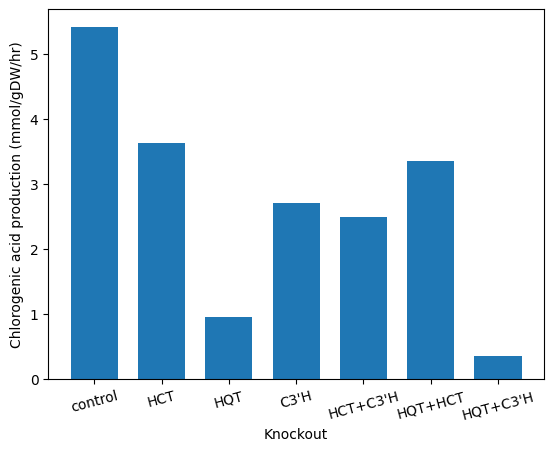

In [289]:
print(result)
plt.bar(result.keys(), result.values(), width=0.7)
plt.xlabel('Knockout')
plt.ylabel('Chlorogenic acid production (mmol/gDW/hr)', fontsize=10)
plt.xticks(rotation=15)
plt.show()

#### 2.2 Analysis in Caffeoylmalic Acid Model

In [290]:
# Caffeoylmalic acid
def Caffeoylmalic_acid_model_copy(): # must be called every time
    model = FBA()

    Caffeoylmalic_acid = cobra.Metabolite('Caffeoylmalic_acid')
    met_0512 = model.model.metabolites.get_by_id('met_0512') # CoA
    met_0417 = model.model.metabolites.get_by_id('met_0417')
    met_2298 = model.model.metabolites.get_by_id('met_2298')

    # HCT_M
    R_HCT_M1 = cobra.Reaction('HCT_M1')
    R_HCT_M1.add_metabolites({met_0417: -1, met_2298: -1, Caffeoylmalic_acid: 1, met_0512: 1})
    R_HCT_M1.bounds = (-1000, 1000)

    # Caffeoylmalic acid proc
    Caffeoylmalic_acid_proc = cobra.Reaction('Caffeoylmalic_acid_proc')
    Caffeoylmalic_acid_proc.add_metabolites({Caffeoylmalic_acid: -1})
    Caffeoylmalic_acid_proc.bounds = (0, 1000)

    model.model.add_reactions([R_HCT_M1, Caffeoylmalic_acid_proc])
    return model

# Caffeoylmalic_acid_coef = 0.53895853355
# Caffeoylmalic_acid_coef = 0.5389585
# Caffeoylmalic_acid_coef = 0.538958502
Caffeoylmalic_acid_coef = 0.538958542
# Caffeoylmalic_acid_coef = 0.538958533

Caff_model_control = Caffeoylmalic_acid_model_copy()

Caff_model_control.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (5.3, 5.4)

result_chlorogenic_acid = {}
result_caffeoylmalic_acid = {}
Caff_model_control.knock_out([])
result_chlorogenic_acid['control'] = Print_res(Caff_model_control, 'chlorogenic_acid_proc', 'met_0418', obj=Caffeoylmalic_acid_coef * Caff_model_control.model.reactions.Caffeoylmalic_acid_proc.flux_expression)
result_caffeoylmalic_acid['control'] = Print_res(Caff_model_control, 'Caffeoylmalic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_control.model.reactions.Caffeoylmalic_acid_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145519426718248
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc: 5.3
reac_0074: 0.0
reac_2013: -1.124895439355198
reac_0017: 4.175104560644802

chlorogenic_acid_proc:  5.3
balanced
1.8145519426718248
photosynthesis 0.88
CO2:  30.0 

Caffeoylmalic_acid_proc:  1.0751045606448022


In [291]:
Caff_model_HCT = Caffeoylmalic_acid_model_copy()

# Caff_model_HCT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (1, 5.4)
Caff_model_HCT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (3.5, 5.4)
Caff_model_HCT.knock_out(['HCT'])
result_chlorogenic_acid['HCT'] = Print_res(Caff_model_HCT, 'chlorogenic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HCT.model.reactions.Caffeoylmalic_acid_proc.flux_expression)
result_caffeoylmalic_acid['HCT'] = Print_res(Caff_model_HCT, 'Caffeoylmalic_acid_proc','met_0418', obj=Caffeoylmalic_acid_coef * Caff_model_HCT.model.reactions.Caffeoylmalic_acid_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.814551877420871
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  3.5
balanced
1.814551877420871
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc: 3.5
reac_0017: 3.0
reac_0074: 0.0
reac_2013: -0.5

Caffeoylmalic_acid_proc:  2.2001000000000004


In [292]:
Caff_model_HQT = Caffeoylmalic_acid_model_copy()

Caff_model_HQT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (0.95, 5.4)


Caff_model_HQT.knock_out(['HQT'])
result_chlorogenic_acid['HQT'] = Print_res(Caff_model_HQT, 'chlorogenic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HQT.model.reactions.Caffeoylmalic_acid_proc.flux_expression)
result_caffeoylmalic_acid['HQT'] = Print_res(Caff_model_HQT, 'Caffeoylmalic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HQT.model.reactions.Caffeoylmalic_acid_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.814551638047526
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  0.95
balanced
1.814551638047526
photosynthesis 0.8
CO2:  30.0 

Caffeoylmalic_acid_proc:  3.089684631241407


In [293]:
Caff_model_C3H = Caffeoylmalic_acid_model_copy()

Caff_model_C3H.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (2.4, 5.4)


Caff_model_C3H.knock_out(['C3\'H'])
result_chlorogenic_acid['C3\'H'] = Print_res(Caff_model_C3H, 'chlorogenic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_C3H.model.reactions.Caffeoylmalic_acid_proc.flux_expression)
result_caffeoylmalic_acid['C3\'H'] = Print_res(Caff_model_C3H, 'Caffeoylmalic_acid_proc', 'met_1352', obj=Caffeoylmalic_acid_coef * Caff_model_C3H.model.reactions.Caffeoylmalic_acid_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145512976208729
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  2.4
balanced
1.8145512976208729
photosynthesis 0.88
CO2:  30.0 

reac_1318: 0.0
CSE: 0.0
4CL: 2.7
R_TAL: 2.2
reac_1317: 0.5

Caffeoylmalic_acid_proc:  0.3001000000000004


In [294]:
Caff_model_HCT_C3H = Caffeoylmalic_acid_model_copy()

Caff_model_HCT_C3H.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (2.2, 5.4)


Caff_model_HCT_C3H.knock_out(['HCT', 'C3\'H'])
result_chlorogenic_acid['HCT+C3\'H'] = Print_res(Caff_model_HCT_C3H, 'chlorogenic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HCT_C3H.model.reactions.Caffeoylmalic_acid_proc.flux_expression)
result_caffeoylmalic_acid['HCT+C3\'H'] = Print_res(Caff_model_HCT_C3H, 'Caffeoylmalic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HCT_C3H.model.reactions.Caffeoylmalic_acid_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.814551306020872
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  2.2
balanced
1.814551306020872
photosynthesis 0.8
CO2:  30.0 

Caffeoylmalic_acid_proc:  0.5001


In [295]:
Caff_model_HQT_HCT = Caffeoylmalic_acid_model_copy()

# Caff_model_HQT_HCT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (3.5, 5.4)
Caff_model_HQT_HCT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (3.3, 5.4)

Caff_model_HQT_HCT.knock_out(['HQT', 'HCT'])
result_chlorogenic_acid['HQT+HCT'] = Print_res(Caff_model_HQT_HCT, 'chlorogenic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HQT_HCT.model.reactions.Caffeoylmalic_acid_proc.flux_expression)
result_caffeoylmalic_acid['HQT+HCT'] = Print_res(Caff_model_HQT_HCT, 'Caffeoylmalic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HQT_HCT.model.reactions.Caffeoylmalic_acid_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145517267818871
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  3.3
balanced
1.8145517267818871
photosynthesis 0.8
CO2:  30.0 

Caffeoylmalic_acid_proc:  1.6379323678431668


In [296]:
Caff_model_HQT_C3H = Caffeoylmalic_acid_model_copy()

Caff_model_HQT_C3H.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (0.35, 5.4)

Caff_model_HQT_C3H.knock_out(['HQT', 'C3\'H'])
result_chlorogenic_acid['HQT+C3\'H'] = Print_res(Caff_model_HQT_C3H, 'chlorogenic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HQT_C3H.model.reactions.Caffeoylmalic_acid_proc.flux_expression)
result_caffeoylmalic_acid['HQT+C3\'H'] = Print_res(Caff_model_HQT_C3H, 'Caffeoylmalic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HQT_C3H.model.reactions.Caffeoylmalic_acid_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145513837208698
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  0.35
balanced
1.8145513837208698
photosynthesis 0.88
CO2:  30.0 

Caffeoylmalic_acid_proc:  2.3500999999999994


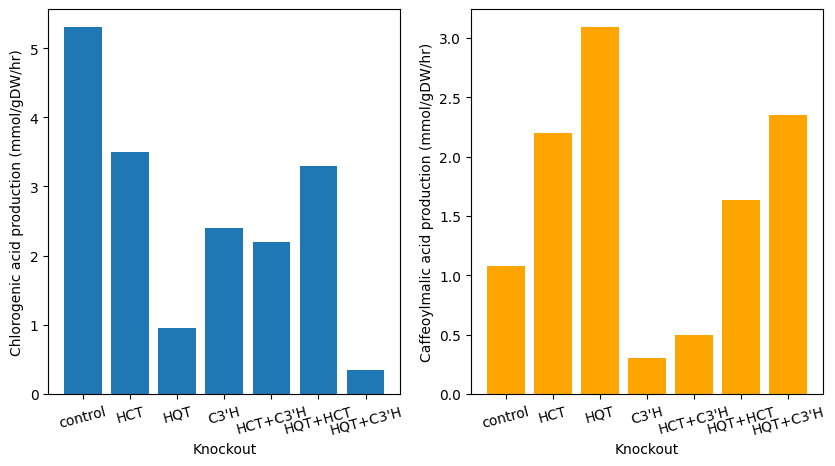

In [297]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(result_chlorogenic_acid.keys(), result_chlorogenic_acid.values())
plt.xlabel('Knockout')
plt.ylabel('Chlorogenic acid production (mmol/gDW/hr)', fontsize=10)
plt.xticks(rotation=15)

plt.subplot(1, 2, 2)
plt.bar(result_caffeoylmalic_acid.keys(), result_caffeoylmalic_acid.values(), color='orange')
plt.xlabel('Knockout')
plt.ylabel('Caffeoylmalic acid production (mmol/gDW/hr)', fontsize=10)
plt.xticks(rotation=15)
plt.show()

#### 2.3 Analysis in Resveratol Model

In [298]:
# Resveratol
def Resveratol_model_copy(): # must be called every time
    model = FBA()

    met_1564 = model.model.metabolites.get_by_id('met_1564') # trans-resveratrol
    met_2484 = model.model.metabolites.get_by_id('met_2484') # (E)-4-coumaroyl-CoA
    met_0512 = model.model.metabolites.get_by_id('met_0512') # coenzymeA
    met_2307 = model.model.metabolites.get_by_id('met_2307') # malonyl-CoA
    met_0429 = model.model.metabolites.get_by_id('met_0429') # CO2
    met_2888 = model.model.metabolites.get_by_id('met_2888') # H2O
    met_0112 = model.model.metabolites.get_by_id("met_0112") # 3-deoxy-D-arabino-heptulosonate7-phosphate
    met_2544 = model.model.metabolites.get_by_id("met_2544") # phosphate
    met_2713 = model.model.metabolites.get_by_id("met_2713") # shikimate3-phosphate
    met_2386 = model.model.metabolites.get_by_id("met_2386") # NADPH
    met_2382 = model.model.metabolites.get_by_id("met_2382") # NADP+
    met_0367 = model.model.metabolites.get_by_id('met_0367') # ATP
    met_0304 = model.model.metabolites.get_by_id('met_0304') # ADP

    # ARO3
    ARO3 = cobra.Reaction('ARO3')
    ARO3.add_metabolites({met_0112:-1, met_2386:-1, met_0367:-1, met_2544:1, met_2888:1, met_2382:1, met_0304:1, met_2713:1})
    ARO3.bounds = (0,1000)

    # VvSTS
    R_VvSTS = cobra.Reaction('VvSTS')
    R_VvSTS.add_metabolites({met_2484: -1, met_2307: -3, met_1564: 1, met_0512: 4, met_0429: 4})
    R_VvSTS.bounds = (0, 1000)
    
    Resveratol_proc = cobra.Reaction('Resveratol_proc')
    Resveratol_proc.add_metabolites({met_1564:-1})
    Resveratol_proc.bounds = (0,1000)

    model.model.add_reactions([ARO3, R_VvSTS, Resveratol_proc])

    return model


Resveratol_coef = 0.5804173
# Resveratol_coef = 0.58041780
Resveratol_model_control = Resveratol_model_copy()

Resveratol_model_control.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (5.3, 5.4)

result_chlorogenic_acid2 = {}
result_Resveratol = {}
Resveratol_model_control.knock_out([])
result_chlorogenic_acid2['control'] = Print_res(Resveratol_model_control, 'chlorogenic_acid_proc', obj=Resveratol_coef * Resveratol_model_control.model.reactions.Resveratol_proc.flux_expression)
result_Resveratol['control'] = Print_res(Resveratol_model_control, 'Resveratol_proc', 'met_2831', obj=Resveratol_coef * Resveratol_model_control.model.reactions.Resveratol_proc.flux_expression )

'' is not a valid SBML 'SId'.


balanced
1.8145521414381556
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  5.3
balanced
1.8145521414381556
photosynthesis 0.88
CO2:  30.0 

reac_2834: 6.118460245901629
reac_0460: 0.0
reac_2840: 0.0
reac_2838: 0.0
reac_2158: 0.0
reac_2489: 0.0
reac_2836: 0.0
reac_2659: 3.9180602459016285
reac_0926: 0.0
reac_1789: 0.0015
reac_2833: 0.0004
reac_2837: -0.0015
reac_2839: 0.0
reac_2167: 1.1

Resveratol_proc:  0.6680602459016289


In [299]:
Resveratol_model_HCT = Resveratol_model_copy()
Resveratol_model_HCT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (3.5, 5.4)
Resveratol_model_HCT.knock_out(['HCT'])
result_chlorogenic_acid2['HCT'] = Print_res(Resveratol_model_HCT, 'chlorogenic_acid_proc', obj=Resveratol_coef * Resveratol_model_HCT.model.reactions.Resveratol_proc.flux_expression)
result_Resveratol['HCT'] = Print_res(Resveratol_model_HCT, 'Resveratol_proc','met_2831', obj=Resveratol_coef * Resveratol_model_HCT.model.reactions.Resveratol_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145518177491773
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  3.5
balanced
1.8145518177491773
photosynthesis 0.88
CO2:  30.0 

reac_2836: 0.0
reac_1789: 0.0
reac_2659: 2.080656593406597
reac_2158: 0.0
reac_2838: 0.0
reac_2167: 1.1
reac_2834: 4.281056593406597
reac_2837: 0.0
reac_2839: 0.0
reac_0460: 0.0
reac_0926: 0.0
reac_2833: 0.0004
reac_2489: 0.0
reac_2840: 0.0

Resveratol_proc:  0.6306565934065977


In [300]:
Resveratol_model_HQT = Resveratol_model_copy()
Resveratol_model_HQT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (0.95, 5.4)
Resveratol_model_HQT.knock_out(['HQT'])
result_chlorogenic_acid2['HQT'] = Print_res(Resveratol_model_HQT, 'chlorogenic_acid_proc', obj=Resveratol_coef * Resveratol_model_HQT.model.reactions.Resveratol_proc.flux_expression)
result_Resveratol['HQT'] = Print_res(Resveratol_model_HQT, 'Resveratol_proc', 'met_1564',obj=Resveratol_coef * Resveratol_model_HQT.model.reactions.Resveratol_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145524659788994
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  0.95
balanced
1.8145524659788994
photosynthesis 0.88
CO2:  30.0 

reac_1434: 0.0
Resveratol_proc: 2.3252298320634446
reac_1549: 0.0
VvSTS: 2.3252298320634446

Resveratol_proc:  2.3252298320634446


In [301]:
Resveratol_model_C3H = Resveratol_model_copy()
Resveratol_model_C3H.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (2.4, 5.4)
Resveratol_model_C3H.knock_out(['C3\'H'])
result_chlorogenic_acid2['C3\'H'] = Print_res(Resveratol_model_C3H, 'chlorogenic_acid_proc', obj=Resveratol_coef * Resveratol_model_C3H.model.reactions.Resveratol_proc.flux_expression)
result_Resveratol['C3\'H'] = Print_res(Resveratol_model_C3H, 'Resveratol_proc', obj=Resveratol_coef * Resveratol_model_C3H.model.reactions.Resveratol_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145524143582783
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  2.4
balanced
1.8145524143582783
photosynthesis 0.8
CO2:  30.0 

Resveratol_proc:  1.8621446497392877


In [302]:
Resveratol_model_HCT_C3H = Resveratol_model_copy()
Resveratol_model_HCT_C3H.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (2.2, 5.4)
Resveratol_model_HCT_C3H.knock_out(['HCT', 'C3\'H'])
result_chlorogenic_acid2['HCT+C3\'H'] = Print_res(Resveratol_model_HCT_C3H, 'chlorogenic_acid_proc', obj=Resveratol_coef * Resveratol_model_HCT_C3H.model.reactions.Resveratol_proc.flux_expression)
result_Resveratol['HCT+C3\'H'] = Print_res(Resveratol_model_HCT_C3H, 'Resveratol_proc', obj=Resveratol_coef * Resveratol_model_HCT_C3H.model.reactions.Resveratol_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145516170683256
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  2.2
balanced
1.8145516170683256
photosynthesis 0.88
CO2:  30.0 

Resveratol_proc:  0.6558973449483168


In [303]:
Resveratol_model_HQT_HCT = Resveratol_model_copy()
Resveratol_model_HQT_HCT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (3.3, 5.4)
Resveratol_model_HQT_HCT.knock_out(['HQT', 'HCT'])
result_chlorogenic_acid2['HQT+HCT'] = Print_res(Resveratol_model_HQT_HCT, 'chlorogenic_acid_proc', obj=Resveratol_coef * Resveratol_model_HQT_HCT.model.reactions.Resveratol_proc.flux_expression)
result_Resveratol['HQT+HCT'] = Print_res(Resveratol_model_HQT_HCT, 'Resveratol_proc', obj=Resveratol_coef * Resveratol_model_HQT_HCT.model.reactions.Resveratol_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.814552449992447
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  3.3
balanced
1.814552449992447
photosynthesis 0.8
CO2:  30.0 

Resveratol_proc:  1.6815670310296054


In [304]:
Resveratol_model_HQT_C3H = Resveratol_model_copy()
Resveratol_model_HQT_C3H.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (0.35, 5.4)
Resveratol_model_HQT_C3H.knock_out(['HQT', 'C3\'H'])
result_chlorogenic_acid2['HQT+C3\'H'] = Print_res(Resveratol_model_HQT_C3H, 'chlorogenic_acid_proc', obj=Resveratol_coef * Resveratol_model_HQT_C3H.model.reactions.Resveratol_proc.flux_expression)
result_Resveratol['HQT+C3\'H'] = Print_res(Resveratol_model_HQT_C3H, 'Resveratol_proc', obj=Resveratol_coef * Resveratol_model_HQT_C3H.model.reactions.Resveratol_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145522577637883
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  0.35
balanced
1.8145522577637883
photosynthesis 0.88
CO2:  30.0 

Resveratol_proc:  2.1543638735177875


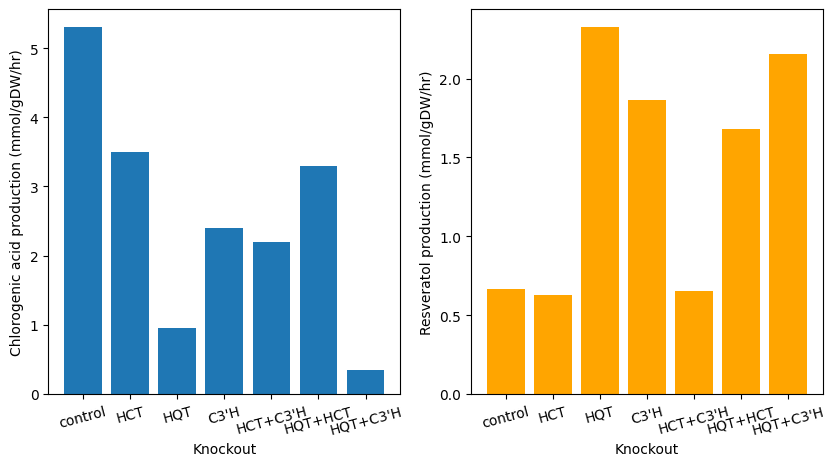

In [305]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(result_chlorogenic_acid2.keys(), result_chlorogenic_acid2.values())
plt.xlabel('Knockout')
plt.ylabel('Chlorogenic acid production (mmol/gDW/hr)', fontsize=10)
plt.xticks(rotation=15)

plt.subplot(1, 2, 2)
plt.bar(result_Resveratol.keys(), result_Resveratol.values(), color='orange')
plt.xlabel('Knockout')
plt.ylabel('Resveratol production (mmol/gDW/hr)', fontsize=10)
plt.xticks(rotation=15)
plt.show()

#### 2.4 Analysis in Crocetin Model

#### 3. dFBA

In [306]:
end_t = 168

#### 3.1 Caffeoylmalic Acid

0.06256563957331007 0.06256563957331153 0.2
0.06400443683755785 0.06400443683755692 0.202
0.06271004550325632 0.06271004550325653 0.20020266770271405
0.06278236566034945 0.06278236566033935 0.20030445763138
0.06314514127300441 0.06314514127300626 0.20081391635992019
0.063209840142882 0.0632098401428773 0.20090475089446255
0.06329080112885377 0.06329080112885116 0.20101841064508372
0.06329080112885377 0.06329080112885116 0.20101841399940537
0.06476481776781995 0.06476481776781193 0.20306541793631774
0.06551381947800294 0.06551381947801027 0.2041352338767198
0.06938172894166694 0.0693817289416722 0.2095380160304259
0.07009125249447656 0.07009125249447355 0.21052417699640363
0.0709876483841958 0.07098764838419154 0.21177241528049073
0.0709876483841958 0.07098764838419154 0.2117759078618581
0.08904671295023858 0.08904671295023472 0.23436057416670056
0.0995675342361717 0.09956753423616405 0.251006286455631
0.17030217994259367 0.17030217994259333 0.34085810687906715
0.18648160441472772 0.186

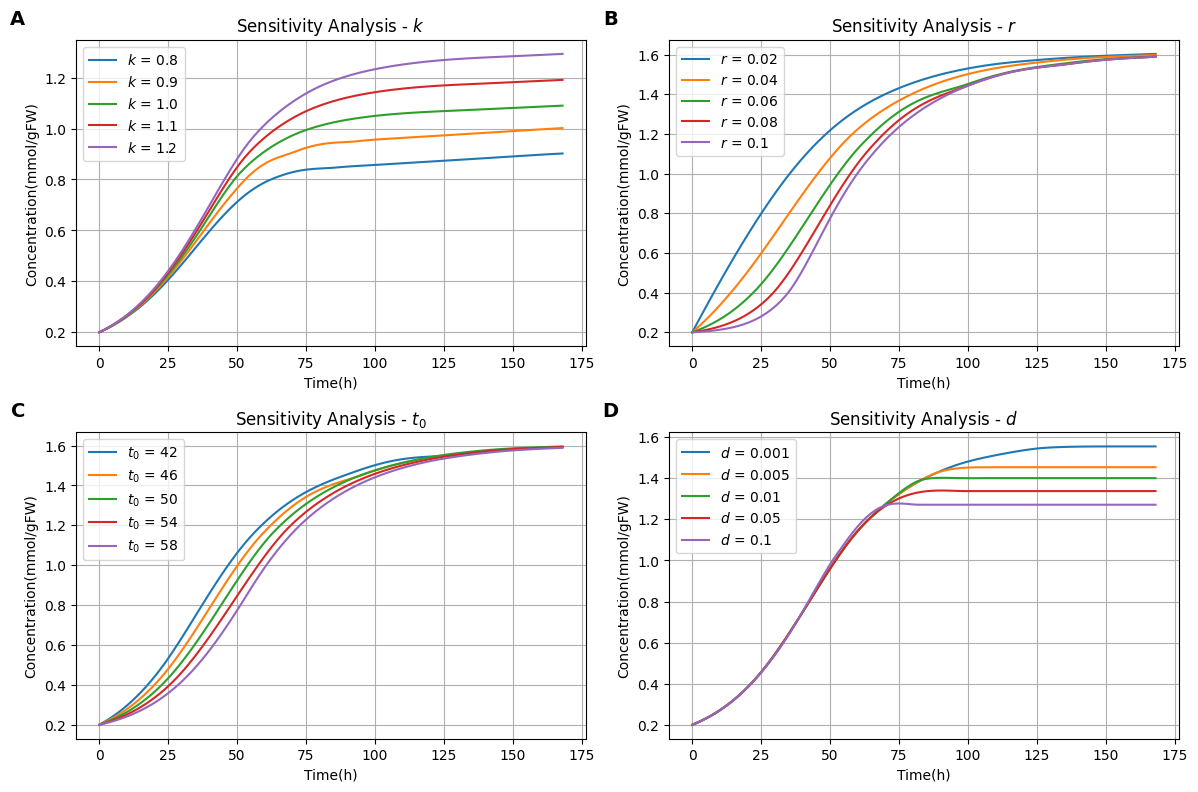

In [307]:
default_i = 0.99
decay_i = 2  # i when analyzing decay

def dynamic_system_caffeoylmalic_acid(t, y, k, model, balanced_flux, r, t_0, threshold, decay, i):
    Caffeoylmalic_Acid = y[0]

    add_dynamic_bounds_caffeoylmalic_acid(model, t, y, balanced_flux, r, t_0, threshold, decay)
    solution = model.model.optimize()
    HCT_M1 = solution.fluxes.get('HCT_M1')
    proc_flux = solution.fluxes.get('Caffeoylmalic_acid_proc')
    print(HCT_M1, proc_flux, Caffeoylmalic_Acid)

    inhibit = min(Caffeoylmalic_Acid / (k * balanced_flux), i)
    d_caffeoylmalic_acid_dt = Dry2Wet * proc_flux * (1 - inhibit)

    return [d_caffeoylmalic_acid_dt]

def add_dynamic_bounds_caffeoylmalic_acid(model, t, y, balanced_flux, r, t_0, threshold, decay):
    Caffeoylmalic_acid_proc = model.model.reactions.get_by_id('Caffeoylmalic_acid_proc')
    if t <= threshold:
        Caffeoylmalic_acid_proc.upper_bound = balanced_flux / (1 + exp(-r * (t - t_0)))
    if t > threshold:
        Caffeoylmalic_acid_proc.upper_bound = max(Caffeoylmalic_acid_proc.upper_bound - decay * (t - threshold), 0)

def sens_analysis(dynamic_system, param_name, param_values, k, model, flux, r, t_0, threshold, decay, i):
    init_caffeoylmalic_acid = 0.2
    y0 = [init_caffeoylmalic_acid]
    t_span = (0, end_t)
    t_eval = np.linspace(t_span[0], t_span[1], 100)

    results = {}
    for value in param_values:
        if param_name == 'k':
            solution = solve_ivp(dynamic_system, t_span, y0, args=(value, model, flux, r, t_0, threshold, decay, i), method='RK45', t_eval=t_eval)
        elif param_name == 'r':
            solution = solve_ivp(dynamic_system, t_span, y0, args=(k, model, flux, value, t_0, threshold, decay, i), method='RK45', t_eval=t_eval)
        elif param_name == 't_0':
            solution = solve_ivp(dynamic_system, t_span, y0, args=(k, model, flux, r, value, threshold, decay, i), method='RK45', t_eval=t_eval)
        elif param_name == 'threshold':
            solution = solve_ivp(dynamic_system, t_span, y0, args=(k, model, flux, r, t_0, value, decay, i), method='RK45', t_eval=t_eval)
        elif param_name == 'decay':
            # Use i = 2 when analyzing decay
            solution = solve_ivp(dynamic_system, t_span, y0, args=(k, model, flux, r, t_0, threshold, value, decay_i), method='RK45', t_eval=t_eval)

        results[value] = solution.y[0]

    return results

def plot_combined_sensitivity_analysis(results_dict, param_names):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    labels = ['A', 'B', 'C', 'D']

    for ax, (param_name, results), label in zip(axes.flatten(), results_dict.items(), labels):
        if param_name == 't_0':
            param_name_label = r'$t_0$'
        elif param_name == 'decay':
            param_name_label = '$d$'
        elif param_name == 'k':
            param_name_label = '$k$'
        elif param_name == 'r':
            param_name_label = '$r$'

        for value, concentration in results.items():
            ax.plot(np.linspace(0, end_t, len(concentration)), concentration, label=f'{param_name_label} = {value}')

        ax.set_xlabel('Time(h)')
        ax.set_ylabel('Concentration(mmol/gFW)')
        ax.set_title(f'Sensitivity Analysis - {param_name_label}')
        ax.legend()
        ax.grid(True)

        ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

    plt.tight_layout()
    plt.savefig("pic/sens_analysis", bbox_inches='tight', dpi=300)
    plt.show()

# Define parameter values for sensitivity analysis
param_values_k = [0.8, 0.9, 1.0, 1.1, 1.2]
param_values_r = [0.02, 0.04, 0.06, 0.08, 0.10]
param_values_t0 = [42, 46, 50, 54, 58]
param_values_decay = [0.001, 0.005, 0.01, 0.05, 0.1]

# Set initial values for parameters
k = 1.5
decay = 0.0002
r = 0.058
t_0 = 48
threshold = 1.4 * t_0
end_t = 168  # Define the end time for the analysis

# Conduct sensitivity analysis for each parameter
sensitivity_results_k = sens_analysis(dynamic_system_caffeoylmalic_acid, 'k', param_values_k, k, Caff_model_control, result_caffeoylmalic_acid['control'], r, t_0, threshold, decay, default_i)
sensitivity_results_r = sens_analysis(dynamic_system_caffeoylmalic_acid, 'r', param_values_r, k, Caff_model_control, result_caffeoylmalic_acid['control'], r, t_0, threshold, decay, default_i)
sensitivity_results_t0 = sens_analysis(dynamic_system_caffeoylmalic_acid, 't_0', param_values_t0, k, Caff_model_control, result_caffeoylmalic_acid['control'], r, t_0, threshold, decay, default_i)
sensitivity_results_decay = sens_analysis(dynamic_system_caffeoylmalic_acid, 'decay', param_values_decay, k, Caff_model_control, result_caffeoylmalic_acid['control'], r, t_0, threshold, decay, decay_i)

# Combine results for plotting
sensitivity_results = {
    'k': sensitivity_results_k,
    'r': sensitivity_results_r,
    't_0': sensitivity_results_t0,
    'decay': sensitivity_results_decay
}

# Plot combined sensitivity analysis
plot_combined_sensitivity_analysis(sensitivity_results, ['k', 'r', 't_0', 'decay'])